In [1]:
import pandas as pd
import networkx as nx
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
#from pprint import pprint
import seaborn as sns
import numpy as np
from collections import Counter

#import graph_tool
#from graph_tool import draw
#from graph_tool import inference

In [2]:
#!pip install --user networkx
#!pip install graph_tool

In [2]:
edges = pd.read_csv("../data/musae_git_edges.csv")
metadata = pd.read_csv("../data/musae_git_target.csv")

In [3]:
metadata.head()

,id,name,ml_target
0,0,Eiryyy,0
1,1,shawflying,0
2,2,JpMCarrilho,1
3,3,SuhwanCha,0
4,4,sunilangadi2,1


In [5]:
edges.head()

,id_1,id_2
0,0,23977
1,1,34526
2,1,2370
3,1,14683
4,1,29982


See number or ML developers vs Web Developers in the dataset

In [6]:
metadata.groupby("ml_target").size()

ml_target
0    27961
1     9739
dtype: int64

In [7]:
#each connection only appers once
edges.groupby(['id_1', 'id_2']).size().reset_index(name='count').sort_values(by='count', ascending=False).head()

,id_1,id_2,count
0,0,23977,1
192665,19222,21321,1
192671,19222,21399,1
192670,19222,21381,1
192669,19222,21375,1


Median GitHub Friend Count: 3.0


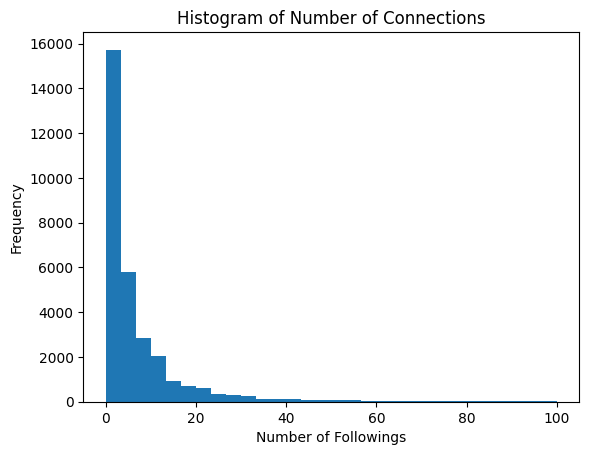

In [8]:
connections = edges.groupby('id_1')['id_2'].count()
sorted_connections = connections.sort_values(ascending=False)

median_connections = connections.median()
print('Median GitHub Friend Count:', median_connections)


plt.hist(connections, bins=30, range=(0, 100))
plt.xlabel('Number of Followings')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Connections')
plt.savefig("plots/hist_nr_connections")
plt.show()


In [9]:
#%matplotlib notebook

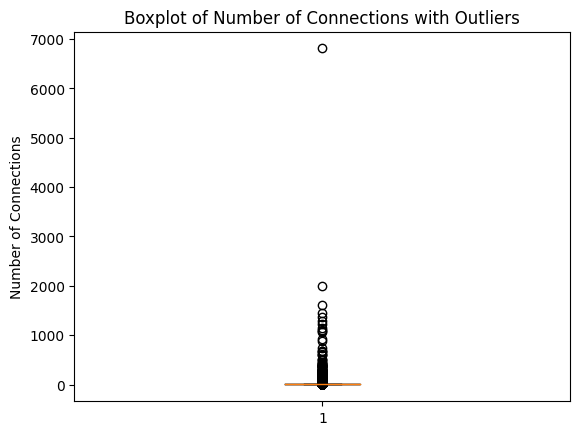

In [10]:
# Explore the outliers, there are accounts with 1000 followings and more
plt.boxplot(connections, showfliers=True)
plt.ylabel('Number of Connections')
plt.title('Boxplot of Number of Connections with Outliers')
plt.savefig("plots/box_nr_connections")
plt.show()

In [11]:


# Merge the datasets based on the common identifier
merged_df = pd.merge(edges, metadata, left_on='id_1', right_on='id')

# Calculate the number of connections for each user account
connections = merged_df.groupby('id')['id_2'].count()

# Calculate the average number of connections for ml_target=0 and ml_target=1
med_connections = merged_df.groupby('ml_target')['id'].apply(lambda x: connections.loc[x].median())

print(med_connections)

ml_target
0    29.0
1    11.0
Name: id, dtype: float64


## Build the Network

In [12]:
G = nx.Graph()

# Add nodes to the graph
for _, row in metadata.iterrows():
    node_id = row['id']
    node_name = row['name']
    ml_target = row['ml_target']

    # Add node to the graph with color based on ml_target
    #color = 'yellow' if ml_target == 1 else 'blue'
    G.add_node(node_id, name=node_name, target=ml_target)
    
    
    
# Add edges to the graph
for _, row in edges.iterrows():
    id_1 = row['id_1']
    id_2 = row['id_2']

    # Add edge between id_1 and id_2
    G.add_edge(id_1, id_2)

In [13]:
#nx.draw_networkx(G)

In [14]:
E = G.number_of_edges()
N = G.order()
print("Number of nodes:", len(G.nodes()))
print("Number of edges:", len(G.edges()))
print ("Average degree=", 2*E/N)
print("Density",nx.density(G))

Number of nodes: 37700
Number of edges: 289003
Average degree= 15.331724137931035
Density 0.0004066878203117068


In [15]:
degree_dct = G.degree()
## Save it as node attribute in the graph object
nx.set_node_attributes(G, dict(degree_dct), name="degree")
metadata['degree'] = metadata["id"].map(dict(degree_dct))
metadata.sort_values("degree",ascending=False).head(10)

,id,name,ml_target,degree
31890,31890,dalinhuang99,0,9458
27803,27803,nfultz,0,7085
35773,35773,addyosmani,0,3324
19222,19222,Bunlong,0,2958
13638,13638,gabrielpconceicao,0,2468
36652,36652,rfthusn,0,2343
18163,18163,nelsonic,0,1924
9051,9051,getify,0,1797
35008,35008,mdo,0,1571
10001,10001,ronenhamias,0,1568


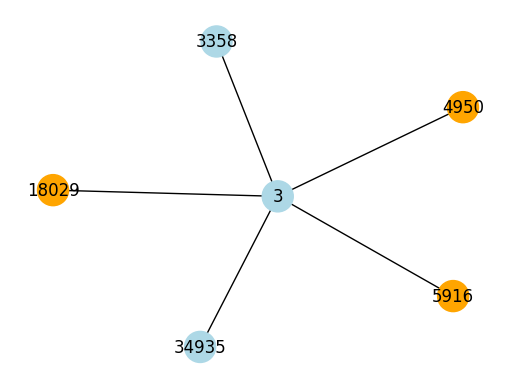

In [53]:
#draw a node with degree 5 with all direct neighbours
node_id = metadata[metadata['degree'] == 5]['id'].tolist()[0]
neighbors = list(G.neighbors(node_id))
# Create a subgraph containing the node and its neighbors
subgraph = G.subgraph([node_id] + neighbors)

#print(G.nodes[32769])

# Get node colors based on the 'ml_target' attribute
node_colors = ['orange' if G.nodes[node]['target'] == 1 else 'lightblue' for node in subgraph.nodes]

# Draw the subgraph
pos = nx.spring_layout(subgraph)
nx.draw_networkx(subgraph, pos, with_labels=True, node_color=node_colors, node_size=500)
# Show the plot
plt.axis('off')
plt.show()




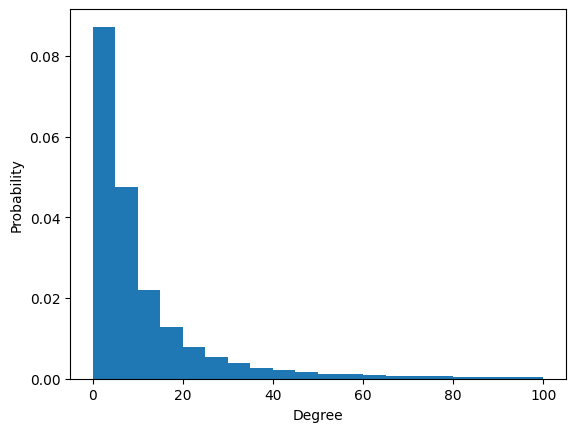

In [52]:
metadata["degree"].hist(bins=20,density=True, range=(0, 100))
# plt.plot(np.arange(0,100),stats.poisson.pmf(np.arange(0,100),2*E/N))
plt.xlabel("Degree")
plt.ylabel("Probability")
plt.gca().grid(False)
plt.savefig("plots/hist_degree")
plt.show()

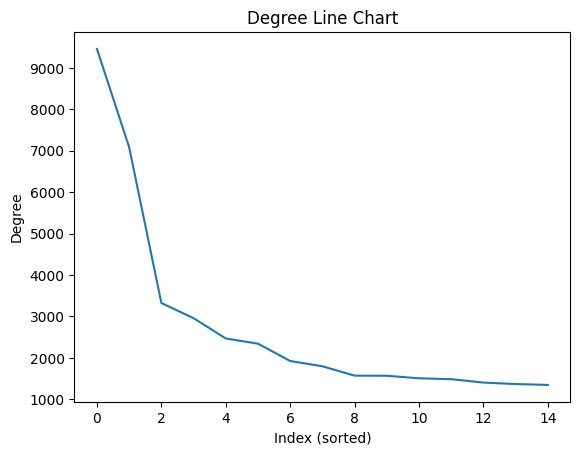

In [61]:
#degreee curve
sorted_m = metadata.sort_values("degree",ascending=False).reset_index().head(15)

plt.plot(sorted_m['degree'])
plt.xlabel('Index (sorted)')
plt.ylabel('Degree')
plt.title('Degree Line Chart')
plt.show()

In [17]:
#Clustering Coefficient
clust_dct = nx.clustering(G)
clustering_coefficient = nx.average_clustering(G)
print("Clustering coefficient:", clustering_coefficient)
nx.set_node_attributes(G,clust_dct,name="clustering")
metadata['clustering'] = metadata.id.map(clust_dct)
metadata.sort_values("clustering",ascending=False).head(10)

Clustering coefficient: 0.16753704480107237


,id,name,ml_target,degree,clustering
34802,34802,Bisawajit,0,2,1.0
30028,30028,francauxach,0,2,1.0
13616,13616,CodingOX,0,2,1.0
9667,9667,tathagatnawadia,1,2,1.0
27076,27076,gauravshelangia,1,2,1.0
7787,7787,TracyMcgrady6,1,2,1.0
12063,12063,Javarome,0,2,1.0
30473,30473,sdeepaknarayanan,1,4,1.0
13624,13624,bingles,0,2,1.0
25536,25536,lazercore,0,2,1.0


In [18]:
#Eigenvector centrality
eigen_dct = nx.eigenvector_centrality(G,max_iter=1000)
nx.set_node_attributes(G,eigen_dct,name="eigenvector")
metadata['eigenvector'] = metadata.id.map(eigen_dct)
metadata.sort_values("eigenvector",ascending=False).head(10)

,id,name,ml_target,degree,clustering,eigenvector
31890,31890,dalinhuang99,0,9458,0.001413,0.355949
27803,27803,nfultz,0,7085,0.003199,0.301655
35773,35773,addyosmani,0,3324,0.004121,0.161677
19222,19222,Bunlong,0,2958,0.006373,0.148842
13638,13638,gabrielpconceicao,0,2468,0.006492,0.119461
36652,36652,rfthusn,0,2343,0.003391,0.095699
7027,7027,jeresig,0,1485,0.008378,0.088758
36628,36628,SuriyaaKudoIsc,0,1507,0.010836,0.087670
9051,9051,getify,0,1797,0.003654,0.082797
3712,3712,isaacs,0,1264,0.009278,0.081374


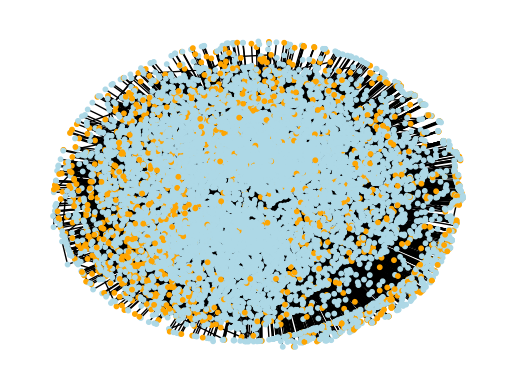

In [54]:
node_id = 31890
neighbors = list(G.neighbors(node_id))
# Create a subgraph containing the node and its neighbors
subgraph = G.subgraph([node_id] + neighbors)

#print(G.nodes[32769])

# Get node colors based on the 'ml_target' attribute
node_colors = ['orange' if G.nodes[node]['target'] == 1 else 'lightblue' for node in subgraph.nodes]

# Draw the subgraph
pos = nx.spring_layout(subgraph)
nx.draw_networkx(subgraph, pos, with_labels=False, node_color=node_colors, node_size=10)
# Show the plot
plt.axis('off')
plt.show()

In [20]:
#PageRank centrality
pr_dct = nx.pagerank(G,max_iter=1000)
nx.set_node_attributes(G,pr_dct,name="pagerank")
metadata['pagerank'] = metadata.id.map(pr_dct)
metadata.sort_values("pagerank",ascending=False).head(10)

,id,name,ml_target,degree,clustering,eigenvector,pagerank
31890,31890,dalinhuang99,0,9458,0.001413,0.355949,0.016514
27803,27803,nfultz,0,7085,0.003199,0.301655,0.011451
35773,35773,addyosmani,0,3324,0.004121,0.161677,0.004919
19222,19222,Bunlong,0,2958,0.006373,0.148842,0.004669
13638,13638,gabrielpconceicao,0,2468,0.006492,0.119461,0.003875
36652,36652,rfthusn,0,2343,0.003391,0.095699,0.003799
18163,18163,nelsonic,0,1924,0.001463,0.055245,0.003381
9051,9051,getify,0,1797,0.003654,0.082797,0.002722
10001,10001,ronenhamias,0,1568,0.006944,0.070280,0.002665
35008,35008,mdo,0,1571,0.004686,0.081334,0.002338


In [21]:
dc_dct = nx.degree_centrality(G)
nx.set_node_attributes(G,dc_dct,name="degree_centrality")
metadata['degree_centrality'] = metadata.id.map(dc_dct)
metadata.sort_values("degree_centrality",ascending=False).head(10)

,id,name,ml_target,degree,clustering,eigenvector,pagerank,degree_centrality
31890,31890,dalinhuang99,0,9458,0.001413,0.355949,0.016514,0.250882
27803,27803,nfultz,0,7085,0.003199,0.301655,0.011451,0.187936
35773,35773,addyosmani,0,3324,0.004121,0.161677,0.004919,0.088172
19222,19222,Bunlong,0,2958,0.006373,0.148842,0.004669,0.078464
13638,13638,gabrielpconceicao,0,2468,0.006492,0.119461,0.003875,0.065466
36652,36652,rfthusn,0,2343,0.003391,0.095699,0.003799,0.062150
18163,18163,nelsonic,0,1924,0.001463,0.055245,0.003381,0.051036
9051,9051,getify,0,1797,0.003654,0.082797,0.002722,0.047667
35008,35008,mdo,0,1571,0.004686,0.081334,0.002338,0.041672
10001,10001,ronenhamias,0,1568,0.006944,0.070280,0.002665,0.041593


In [22]:
#Betweenness centrality
#betwn_dct = nx.betweenness_centrality(G)
#nx.set_node_attributes(G,betwn_dct,name="betweenness")
#metadata['betweenness'] = metadata.id.map(betwn_dct)
#metadata.sort_values("betweenness",ascending=False).head(10)

In [23]:
#Closeness centrality
#close_dct = nx.closeness_centrality(G)
#nx.set_node_attributes(G,close_dct,name="closeness")
#metadata['closeness'] = metadata.id.map(close_dct)
#metadata.sort_values("closeness",ascending=False).head(10)

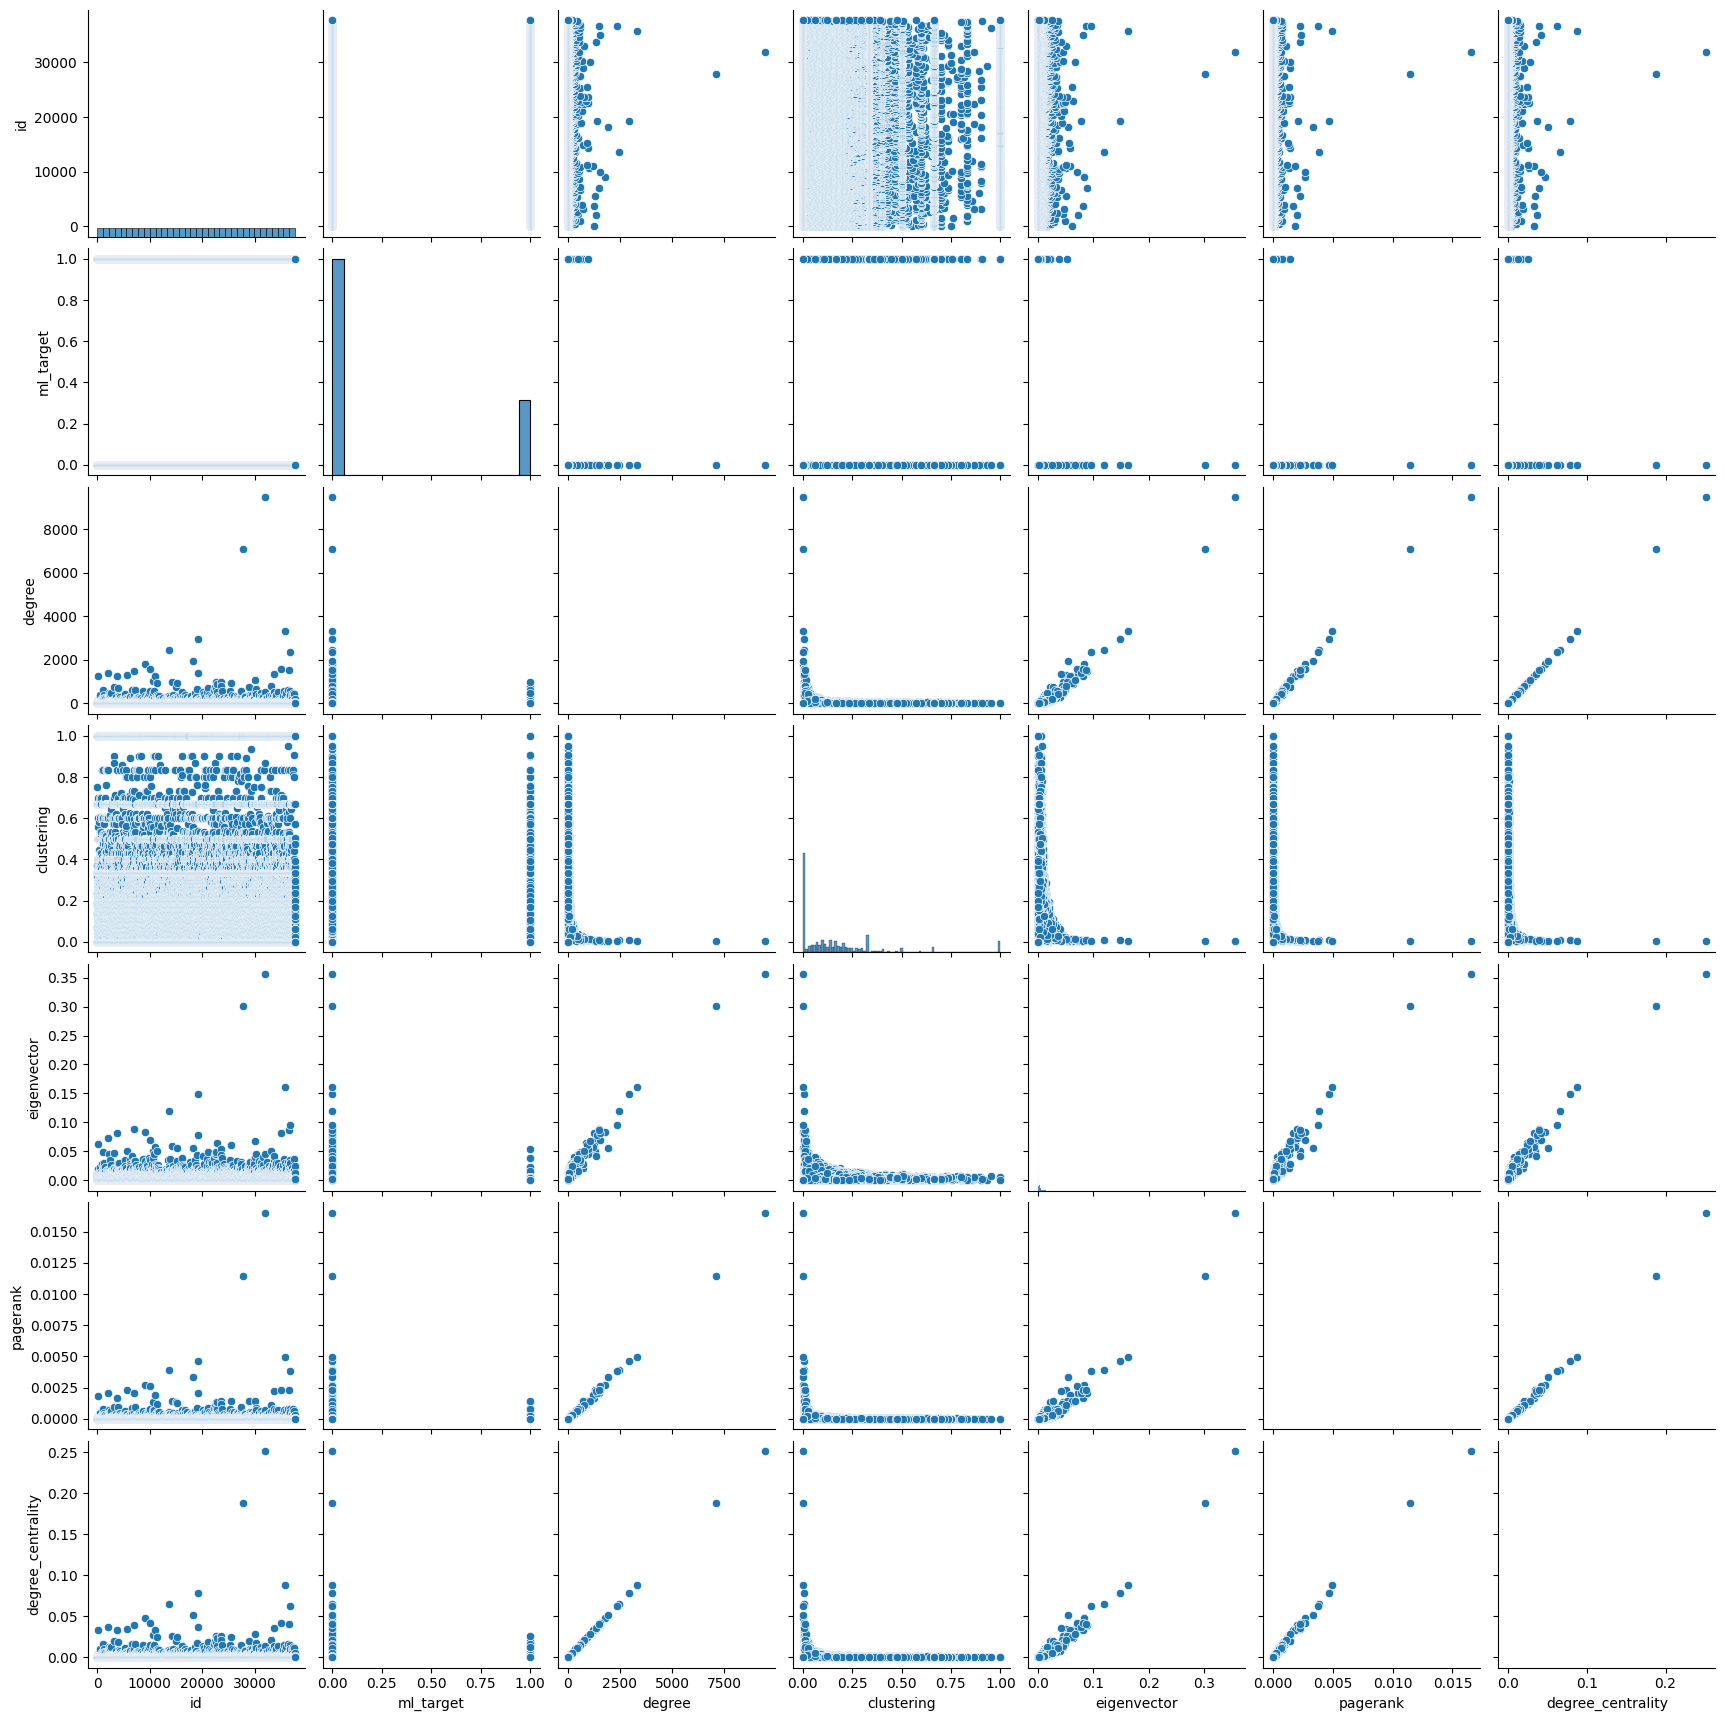

In [24]:
#Correlation between Features
sns.pairplot(metadata)

#### Community Analysis

In [25]:
#run brew install graph-tool

#import graph_tool
#from graph_tool import draw
#from graph_tool import inference

In [26]:
#k-core decomposition

cores_dct = {}
for ki in range(1,40):
    node_lst_i = nx.k_core(G,ki).nodes
    cores_dct_i = {ni:ki for ni in node_lst_i}
    cores_dct.update(cores_dct_i)
    #print (len(node_lst_i))
    if len(node_lst_i) <= 0:
        break

In [27]:
nx.set_node_attributes(G, cores_dct, name="k-core")
metadata['k-core'] = metadata.id.map(cores_dct)
metadata.sort_values("k-core",ascending=False).head(10)

,id,name,ml_target,degree,clustering,eigenvector,pagerank,degree_centrality,k-core
18850,18850,hustcc,0,295,0.035074,0.023466,0.000382,0.007825,34
18701,18701,Natshah,0,176,0.054675,0.020718,0.000255,0.004669,34
23837,23837,airyland,0,188,0.071851,0.021063,0.000233,0.004987,34
23838,23838,ai,0,576,0.012723,0.037857,0.000795,0.015279,34
4128,4128,kangax,0,347,0.026336,0.030544,0.000447,0.009204,34
18876,18876,josh,0,302,0.033971,0.025808,0.000395,0.008011,34
4193,4193,sunsipeng,0,97,0.085911,0.016240,0.000122,0.002573,34
34536,34536,DIYgod,0,529,0.024675,0.029921,0.000712,0.014032,34
23958,23958,Brooooooklyn,0,116,0.091754,0.013125,0.000140,0.003077,34
4370,4370,PixelsCommander,0,155,0.043318,0.015531,0.000239,0.004112,34


In [28]:
nx.write_gexf(G,"result_graph.gexf")

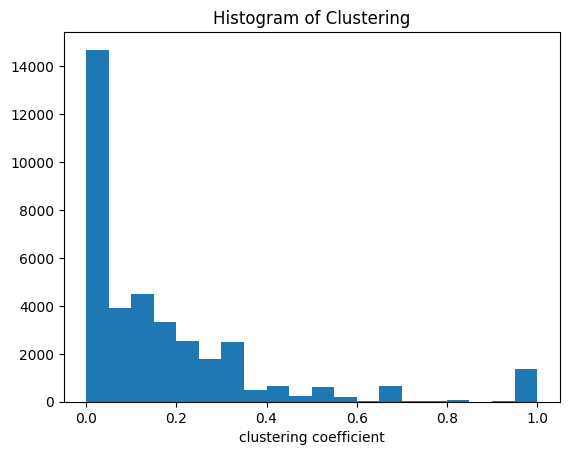

In [29]:
plt.hist(metadata["clustering"], bins=20)
plt.xlabel('clustering coefficient')
#plt.ylabel('Y-axis label')
plt.title('Histogram of Clustering')
plt.savefig("plots/hist_clustering")

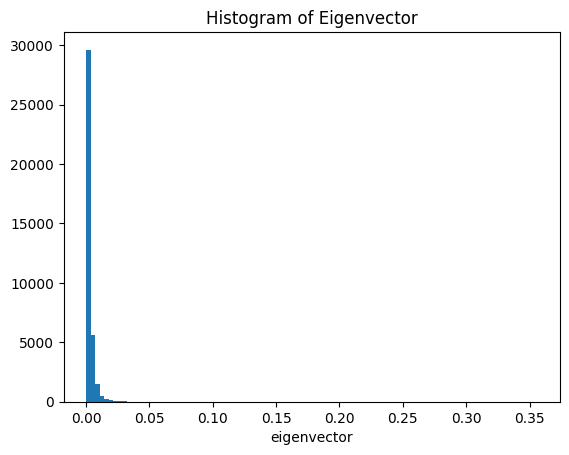

In [30]:
plt.hist(metadata["eigenvector"], bins=100)
plt.xlabel('eigenvector')
#plt.ylabel('Y-axis label')
plt.title('Histogram of Eigenvector')
plt.savefig("plots/hist_eigenvector")

Text(0.5, 1.0, 'Histogram of K-Core')

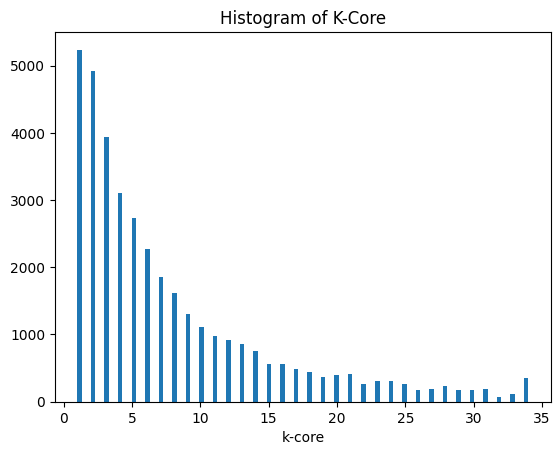

In [31]:
plt.hist(metadata["k-core"], bins=100)
plt.xlabel('k-core')
#plt.ylabel('Y-axis label')
plt.title('Histogram of K-Core')

In [32]:
metadata.to_csv("data/metadata_p.csv",index=False)